In [1]:
## LIBRERIAS ##
#libraries
import numpy as np 
import pandas as pd 
pd.set_option('display.max_columns', None)
import os
import json

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
#import lightgbm as lgb
#import xgboost as xgb
import time
import datetime
from PIL import Image

import gc
#from catboost import CatBoostClassifier
from tqdm import tqdm_notebook
#import plotly.offline as py
#py.init_notebook_mode(connected=True)
#import plotly.graph_objs as go
#import plotly.tools as tls
import random
import warnings
warnings.filterwarnings("ignore")
from functools import partial

#Gradient Boosting
import lightgbm as lgb

#Funciones auxiliares sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold #Split y cross Validation
from sklearn.metrics import cohen_kappa_score, accuracy_score, balanced_accuracy_score #Metricas
from sklearn.preprocessing import OneHotEncoder

# from sklearn.utils import shuffle 

#Visualizacióon
from plotly import express as px

#Plot de matriz de confusion normalizada en actuals
from utils import plot_confusion_matrix

#Optimizacion de hiperparametros
import optuna
from optuna.artifacts import FileSystemArtifactStore, upload_artifact

#Guardado de objetos en archivos joblib
from joblib import load, dump


In [2]:
# Paths para acceso archivos
#Este notebook asume la siguiente estructura de carpetas a partir de la ubicacion de base_dir 
#(dos niveles arriba de la carpeta donde se ejecuta el notebook). 
# /UA_MDM_LDI_II/
# /UA_MDM_LDI_II/input
# /UA_MDM_LDI_II/input/petfinder-adoption-prediction/            <- Aca deben ir todos los archivos de datos de la competencia 
# /UA_MDM_LDI_II/tutoriales/                       <- Aca deben poner los notebooks y scripts que les compartimos
# /UA_MDM_LDI_II/work/                             <- Resultados de notebooks iran dentro de esta carpeta en subcarpetas
# /UA_MDM_LDI_II/work/models/                     <- Modelos entrenados en archivos joblibs
# /UA_MDM_LDI_II/work/optuna_temp_artifacts/      <- Archivos que queremos dejar como artefacto de un trial de optuna (optuna los copiara a la carpeta de abajo)
# /UA_MDM_LDI_II/work/optuna_artifacts/           <- Archivos con artefactos que sibimos a optuna

#Subimos dos niveles para quedar en la carpeta que contiene input y UA_MDM_LDI_II
BASE_DIR = ''

#Datos de entrenamiento 
PATH_TO_TRAIN = os.path.join(BASE_DIR, "input/petfinder-adoption-prediction/train/train.csv")

#Datos de test
PATH_TO_TEST = os.path.join(BASE_DIR, "input/petfinder-adoption-prediction/test/test.csv")

#Salida de modelos entrenados
PATH_TO_MODELS = os.path.join(BASE_DIR, "work/models")

#Artefactos a subir a optuna
PATH_TO_TEMP_FILES = os.path.join(BASE_DIR, "work/optuna_temp_artifacts")

#Artefactos que optuna gestiona
PATH_TO_OPTUNA_ARTIFACTS = os.path.join(BASE_DIR, "work/optuna_artifacts")


SEED = 42 #Semilla de procesos aleatorios (para poder replicar exactamente al volver a correr un modelo)
TEST_SIZE = 0.2 #Facción para train/test= split 

#PONER CUALQUIER SEMILLLA Y 20% DEL DATASTE USAMOS

In [3]:
# Datos Tabulares
dataset = pd.read_csv(PATH_TO_TRAIN)

## EDA

In [4]:
dataset.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2
1,2,No Name Yet,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0
2,1,Brisco,1,307,0,1,2,7,0,2,2,1,1,2,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3
3,1,Miko,4,307,0,2,1,2,0,2,1,1,1,2,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2
4,1,Hunter,1,307,0,1,1,0,0,2,1,2,2,2,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2


In [5]:
dataset.describe()

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,VideoAmt,PhotoAmt,AdoptionSpeed
count,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000
mean,1.457614,10.452078,265.272594,74.009738,1.776162,2.234176,3.222837,1.882012,1.862002,1.467485,1.731208,1.558727,1.914227,1.036617,1.576069,21.259988,41346.028347,0.056760,3.889215,2.516441
std,0.498217,18.155790,60.056818,123.011575,0.681592,1.745225,2.742562,2.984086,0.547959,0.599070,0.667649,0.695817,0.566172,0.199535,1.472477,78.414548,32.444153,0.346185,3.487810,1.177265
min,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,41324.000000,0.000000,0.000000,0.000000
25%,1.000000,2.000000,265.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,0.000000,41326.000000,0.000000,2.000000,2.000000
50%,1.000000,3.000000,266.000000,0.000000,2.000000,2.000000,2.000000,0.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,0.000000,41326.000000,0.000000,3.000000,2.000000
75%,2.000000,12.000000,307.000000,179.000000,2.000000,3.000000,6.000000,5.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,0.000000,41401.000000,0.000000,5.000000,4.000000
max,2.000000,255.000000,307.000000,307.000000,3.000000,7.000000,7.000000,7.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,20.000000,3000.000000,41415.000000,8.000000,30.000000,4.000000


In [6]:
# Tamaño del dataset
print(dataset.shape)     # 14993 registros, 24 variables

# Name of columns
print(dataset.columns)

#Revisar tipo y nulos
dataset.info()
dataset.isnull().sum()

(14993, 24)
Index(['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Type           14993 non-null  int64  
 1   Name           13728 non-null  object 
 2   Age            14993 non-null  int64  
 3   Breed1         14993 non-null  int64  
 4   Breed2         14993 non-null  int64  
 5   Gender         14993 non-null  int64  
 6   Color1         14993 non-null  int64  
 7   Color2         14993 non-null  int64  
 8   Color3         14993 non-null  int64  
 9   MaturitySize   14993 non-null  int64  
 10  FurLength      14993 non-nu

Type                0
Name             1265
Age                 0
Breed1              0
Breed2              0
Gender              0
Color1              0
Color2              0
Color3              0
MaturitySize        0
FurLength           0
Vaccinated          0
Dewormed            0
Sterilized          0
Health              0
Quantity            0
Fee                 0
State               0
RescuerID           0
VideoAmt            0
Description        13
PetID               0
PhotoAmt            0
AdoptionSpeed       0
dtype: int64

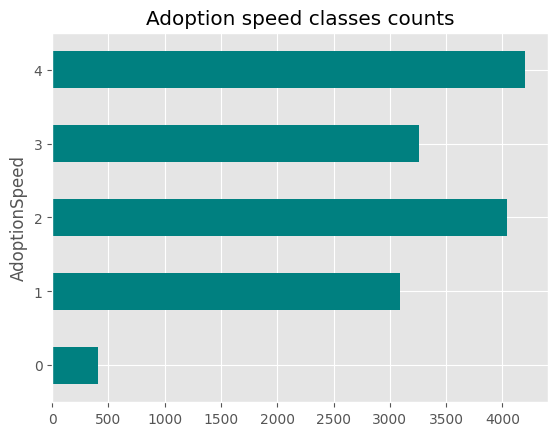

In [7]:
dataset['AdoptionSpeed'].value_counts().sort_index().plot(kind='barh', color='teal')
plt.title('Adoption speed classes counts')
plt.show()

#0 - La mascota fue adoptada el mismo día en que fue registrada.
#1 - La mascota fue adoptada entre 1 y 7 días (1ra semana) después de ser registrada.
#2 - La mascota fue adoptada entre 8 y 30 días (1er mes) después de ser registrada.
#3 - La mascota fue adoptada entre 31 y 90 días (2do y 3er mes) después de ser registrada.
#4 - No hubo adopción después de 100 días de ser registrada. (No hay mascotas en este conjunto de datos que hayan esperado entre 90 y 100 días).

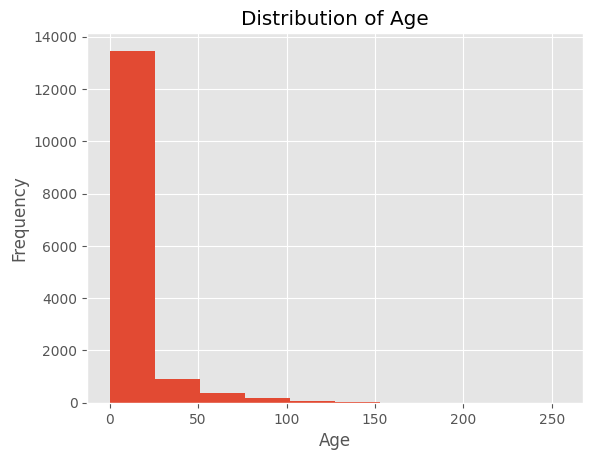

In [8]:
# Univariate Analysis
# Histogram for Age
plt.hist(dataset['Age'])
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

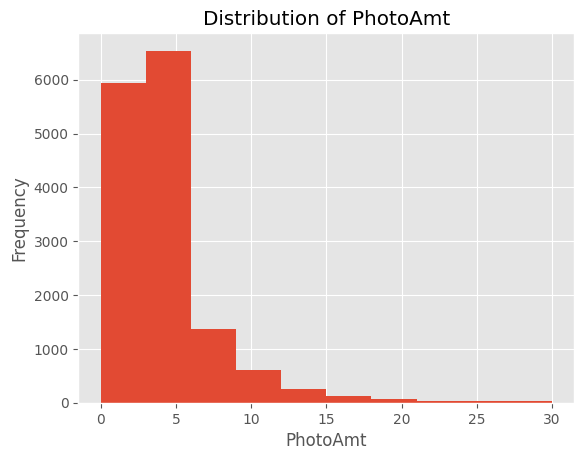

In [9]:
# Univariate Analysis
# Histogram for PhotoAmt
plt.hist(dataset['PhotoAmt'])
plt.title('Distribution of PhotoAmt')
plt.xlabel('PhotoAmt')
plt.ylabel('Frequency')
plt.show()

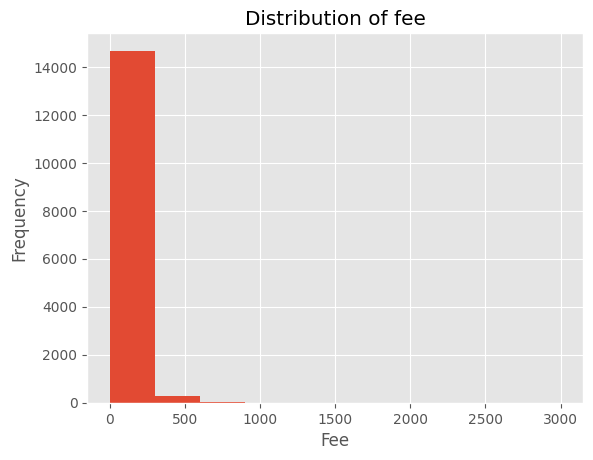

In [10]:
# Univariate Analysis
# Histogram for PhotoAmt
plt.hist(dataset['Fee'])
plt.title('Distribution of fee')
plt.xlabel('Fee')
plt.ylabel('Frequency')
plt.show()

In [11]:
# Missing values per variable

# Cambio variables no especificadas (ejemplo: 0) a NA
dataset['MaturitySize'] = dataset['MaturitySize'].replace(0, pd.NA)
dataset['FurLength'] = dataset['FurLength'].replace(0, pd.NA)
dataset['Vaccinated'] = dataset['Vaccinated'].replace(3, pd.NA)
dataset['Dewormed'] = dataset['Dewormed'].replace(3, pd.NA)
dataset['Sterilized'] = dataset['Sterilized'].replace(3, pd.NA)
dataset['Health'] = dataset['Health'].replace(0, pd.NA)

missing_values = dataset.isnull().sum()
missing_values = missing_values[missing_values > 0]
print("Campos faltantes por variable:")
print(missing_values)

Campos faltantes por variable:
Name           1265
Vaccinated     1868
Dewormed       1781
Sterilized     1815
Description      13
dtype: int64


In [12]:
# Dataset summary
print(dataset.describe())

               Type           Age        Breed1        Breed2        Gender  \
count  14993.000000  14993.000000  14993.000000  14993.000000  14993.000000   
mean       1.457614     10.452078    265.272594     74.009738      1.776162   
std        0.498217     18.155790     60.056818    123.011575      0.681592   
min        1.000000      0.000000      0.000000      0.000000      1.000000   
25%        1.000000      2.000000    265.000000      0.000000      1.000000   
50%        1.000000      3.000000    266.000000      0.000000      2.000000   
75%        2.000000     12.000000    307.000000    179.000000      2.000000   
max        2.000000    255.000000    307.000000    307.000000      3.000000   

             Color1        Color2        Color3  MaturitySize     FurLength  \
count  14993.000000  14993.000000  14993.000000  14993.000000  14993.000000   
mean       2.234176      3.222837      1.882012      1.862002      1.467485   
std        1.745225      2.742562      2.984086    

### Variables Base
- PetID - Unique hash ID of pet profile
- AdoptionSpeed - Categorical speed of adoption. Lower is faster. This is the value to predict. See below section for more info.
- Type - Type of animal (1 = Dog, 2 = Cat)
- Name - Name of pet (Empty if not named)
- Age - Age of pet when listed, in months
- Breed1 - Primary breed of pet (Refer to BreedLabels dictionary)
- Breed2 - Secondary breed of pet, if pet is of mixed breed (Refer to BreedLabels dictionary)
- Gender - Gender of pet (1 = Male, 2 = Female, 3 = Mixed, if profile represents group of pets)
- Color1 - Color 1 of pet (Refer to ColorLabels dictionary)
- Color2 - Color 2 of pet (Refer to ColorLabels dictionary)
- Color3 - Color 3 of pet (Refer to ColorLabels dictionary)
- MaturitySize - Size at maturity (1 = Small, 2 = Medium, 3 = Large, 4 = Extra Large, 0 = Not Specified)
- FurLength - Fur length (1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified)
- Vaccinated - Pet has been vaccinated (1 = Yes, 2 = No, 3 = Not Sure)
- Dewormed - Pet has been dewormed (1 = Yes, 2 = No, 3 = Not Sure)
- Sterilized - Pet has been spayed / neutered (1 = Yes, 2 = No, 3 = Not Sure)
- Health - Health Condition (1 = Healthy, 2 = Minor Injury, 3 = Serious Injury, 0 = Not Specified)
- Quantity - Number of pets represented in profile
- Fee - Adoption fee (0 = Free)
- State - State location in Malaysia (Refer to StateLabels dictionary)
- RescuerID - Unique hash ID of rescuer
- VideoAmt - Total uploaded videos for this pet
- PhotoAmt - Total uploaded photos for this pet
- Description - Profile write-up for this pet. The primary language used is English, with some in Malay or Chinese.

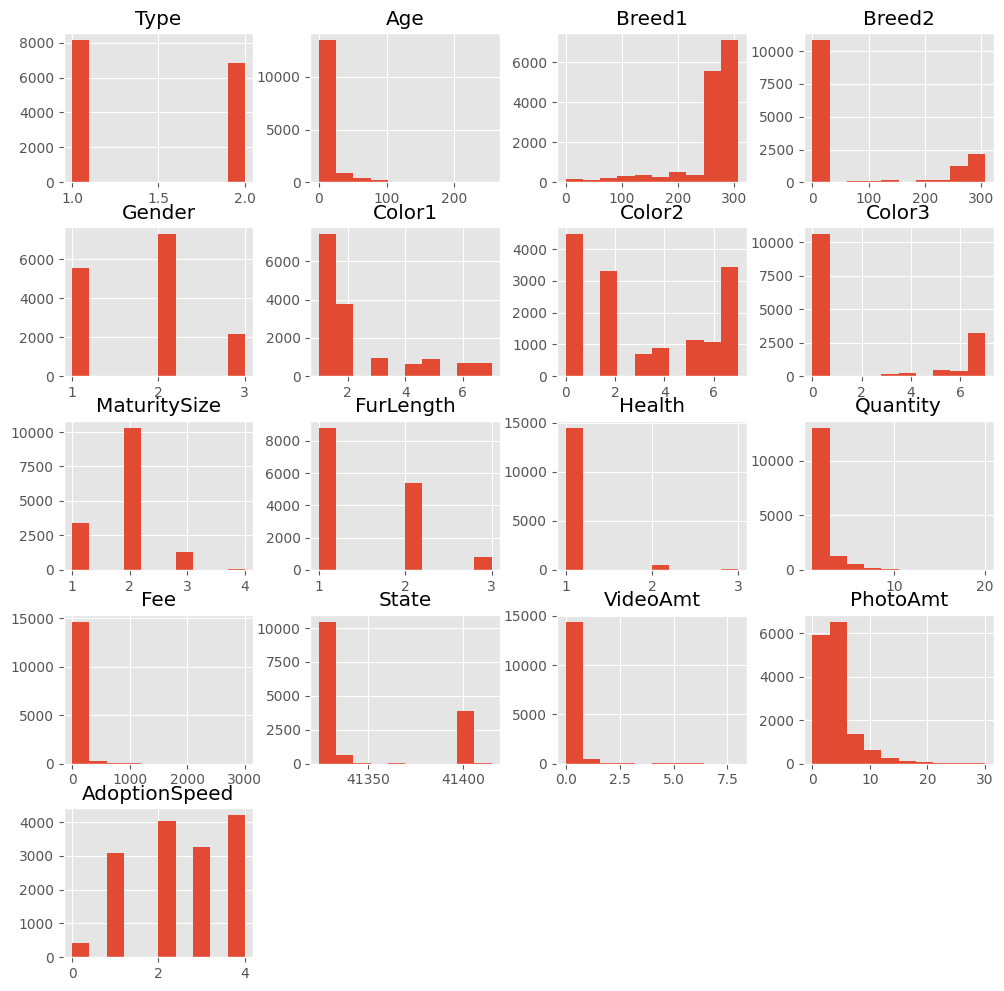

In [13]:
# Variables histograms

import matplotlib.pyplot as plt

dataset.hist(figsize=(12, 12))
plt.show()

In [14]:
# Pets of mixed breed (Breed1 = 307)
count = dataset[dataset['Breed1'] == 307].shape[0]
print(count)    # 1499

# Las 10 razas mas comunes (Breed1)
breed_counts = dataset['Breed1'].value_counts()
most_common_breeds = breed_counts.nlargest(10)
print(most_common_breeds)
#most_common_breeds_names = df_breeds[df_breeds['BreedID'].isin(most_common_breeds.index)]['BreedName']
#for breed, count in zip(most_common_breeds_names, most_common_breeds):
#    print(f"{breed}: {count}")

# Las 10 razas mas comunes (Breed2)
breed2_counts = dataset['Breed2'].value_counts()
most_common_breeds2 = breed2_counts.nlargest(10)
print(most_common_breeds2)



5927
Breed1
307    5927
266    3634
265    1258
299     342
264     296
292     264
285     221
141     205
205     190
179     167
Name: count, dtype: int64
Breed2
0      10762
307     1727
266      599
265      321
299      138
264      125
292      105
218       91
141       86
285       78
Name: count, dtype: int64


In [23]:
# Correlation of variables

df_numerical = dataset.select_dtypes(include=['int64', 'float64'])

df_numerical.corr().style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

#sns.pairplot(df, hue="AdoptionSpeed")
#plt.show()

## Analisis exploratorio clase 7

Text(0.5, 1.0, 'Adoption speed classes counts')

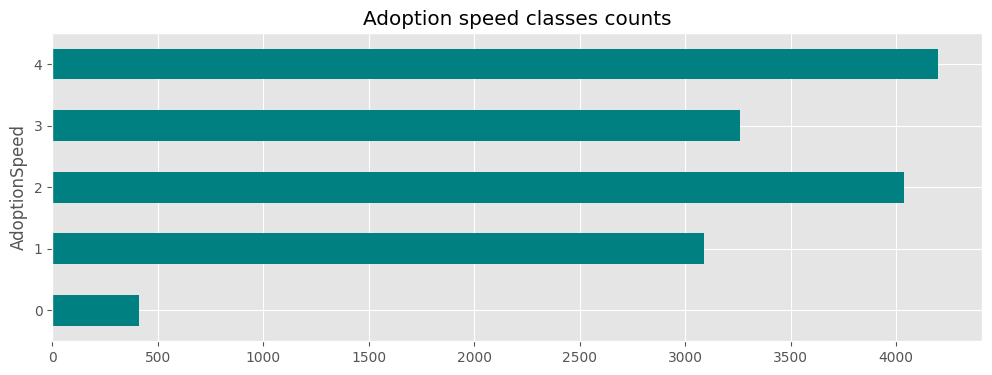

In [16]:
plt.figure(figsize=(12, 4))
dataset['AdoptionSpeed'].value_counts().sort_index().plot(kind='barh', color='teal')
plt.title('Adoption speed classes counts')

AdoptionSpeed    0     1     2     3     4
HasName                                   
False           26   273   313   218   435
True           384  2817  3724  3041  3762


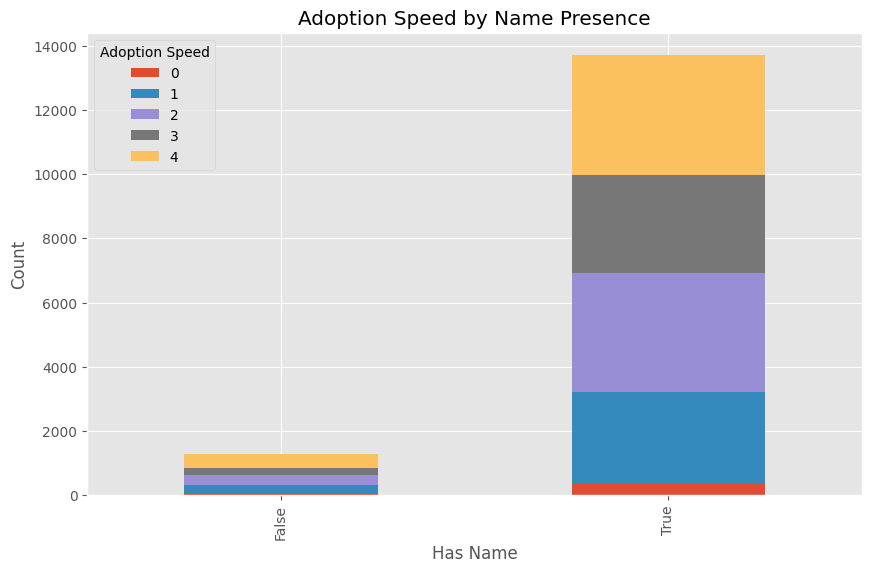

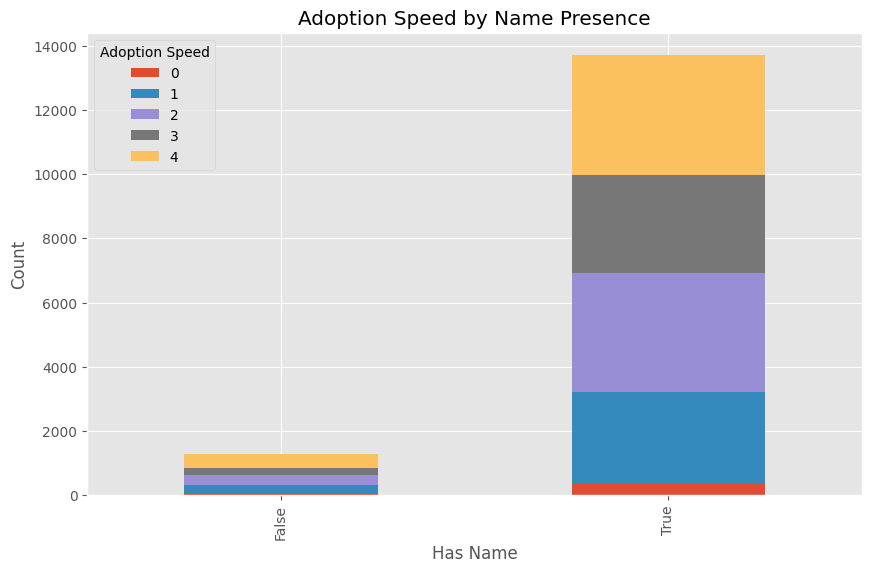

In [17]:
# Create a new column to indicate if the pet has a name
dataset['HasName'] = dataset['Name'].notnull()

# Group by 'HasName' and 'AdoptionSpeed' and count the occurrences
adoption_speed_name = dataset.groupby(['HasName', 'AdoptionSpeed']).size().unstack()

# Display the table
print(adoption_speed_name)

# Display the frequency
adoption_speed_name.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Adoption Speed by Name Presence')
plt.xlabel('Has Name')
plt.ylabel('Count')
plt.legend(title='Adoption Speed')
plt.show()
adoption_speed_name = dataset.groupby(['HasName', 'AdoptionSpeed']).size().unstack()

# Plot the data
adoption_speed_name.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Adoption Speed by Name Presence')
plt.xlabel('Has Name')
plt.ylabel('Count')
plt.legend(title='Adoption Speed')
plt.show()

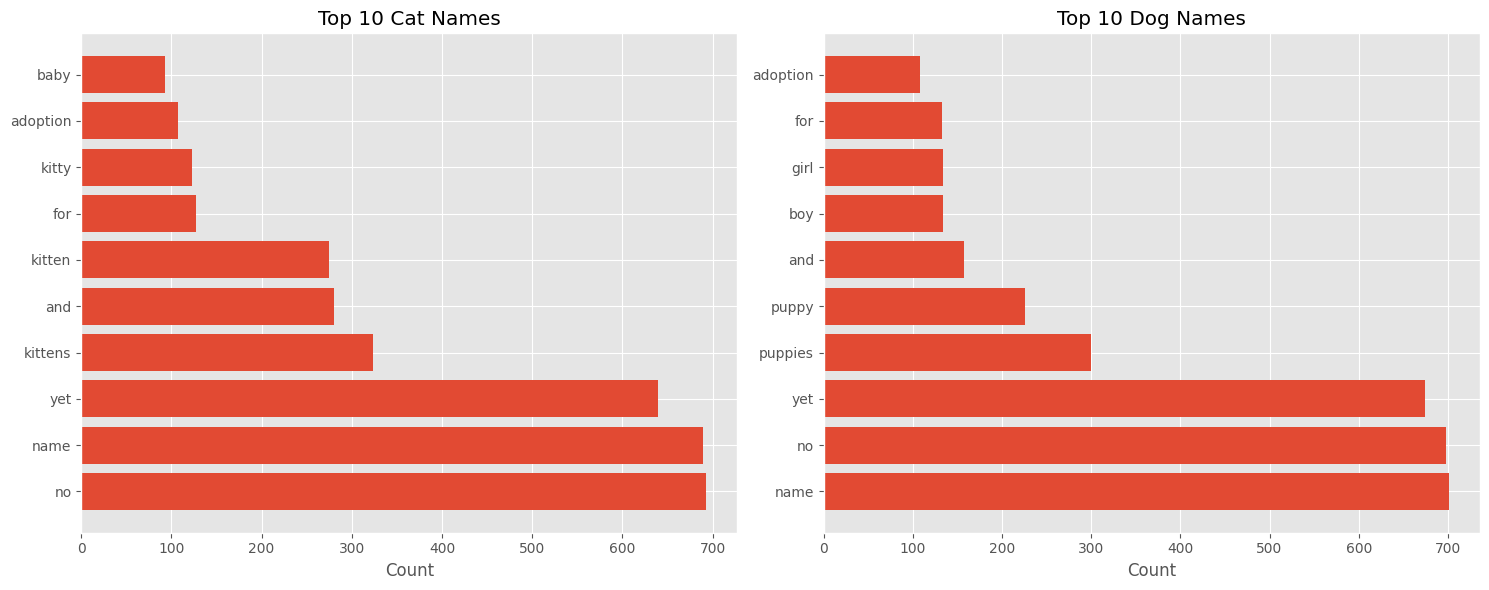

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# Assuming your dataset is already loaded into a DataFrame called 'dataset'

dataset['Name'].fillna('No Name Yet', inplace=True)

# 1. Separate cat and dog names
cat_names = dataset[dataset['Type'] == 2]['Name']
dog_names = dataset[dataset['Type'] == 1]['Name']

# 2. Create a function to get top N words
def get_top_n_words(corpus, n=10):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# 3. Get top 10 words for cats and dogs
top_cat_words = get_top_n_words(cat_names, 10)
top_dog_words = get_top_n_words(dog_names, 10)

# 4. Prepare data for plotting
cat_words, cat_counts = zip(*top_cat_words)
dog_words, dog_counts = zip(*top_dog_words)

# 5. Create a side-by-side bar plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Cat plot
ax1.barh(cat_words, cat_counts)
ax1.set_title('Top 10 Cat Names')
ax1.set_xlabel('Count')

# Dog plot
ax2.barh(dog_words, dog_counts)
ax2.set_title('Top 10 Dog Names')
ax2.set_xlabel('Count')

# Adjust layout and display
plt.tight_layout()
plt.show()

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert 'AdoptionSpeed' to datetime for plotting
dataset['AdoptionSpeedDate'] = pd.to_datetime(dataset['AdoptionSpeed'], unit='D', origin='unix')

# Create a dictionary to map numeric values to labels
type_map = {1: 'Dog', 2: 'Cat'}
# Normalize the counts to get the frequency
adoption_speed_timeline = adoption_speed_timeline.div(adoption_speed_timeline.sum(axis=1), axis=0)
# Apply the mapping to create a new column 'TypeLabel'
dataset['TypeLabel'] = dataset['Type'].map(type_map)

# Group by 'AdoptionSpeedDate' and 'TypeLabel' and count the occurrences
adoption_speed_timeline = dataset.groupby(['AdoptionSpeedDate', 'TypeLabel']).size().unstack(fill_value=0)

# Plot the data
plt.figure(figsize=(14, 7))
adoption_speed_timeline.plot(kind='line', marker='o', ax=plt.gca())
plt.title('Timeline of Adoption Speed Differentiated by Type')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend(title='Type')
plt.grid(True)
plt.show()

NameError: name 'adoption_speed_timeline' is not defined

## FE

In [21]:

def feature_engineering(dataset):
    # Age categorization
    bins = [0, 12, 60, float('inf')]
    labels = [1, 2, 3]  # 1='puppy' 2='adult' 3='senior'
    dataset['AgeCategory'] = pd.cut(dataset['Age'], bins, labels=labels, right=False)

    # Breed combination
    dataset['Breed'] = dataset.apply(lambda row: 2 if row['Breed2'] != 0 else 1, axis=1)

    # Color
    dataset['IsMultiColored'] = dataset.apply(lambda row: 1 if row['Color2'] != 0 or row['Color3'] != 0 else 0, axis=1)

    # Name processing
    dataset['Name'].fillna('No Name Yet', inplace=True) # Fill missing values
    dataset['Name'] = dataset['Name'].replace('', 'No Name Yet') # Replace empty strings
    dataset['name_code'] = dataset['Name'].apply(lambda x: 1 if x != 'No Name Yet' else 0) # Create a binary variable for name presence
    dataset['Is_Genuine_Name'] = ((dataset['Name'] != 'No Name Yet') & (dataset['Quantity'] > 1)).astype(int)    #geniuine name

    # Logarithmic transformations and means
    dataset['Age_log'] = np.log1p(dataset['Age'])
    dataset['PhotoAmt_log'] = np.log1p(dataset['PhotoAmt'])
    dataset['VideoAmt_log'] = np.log1p(dataset['VideoAmt'])
    dataset['Fee_log'] = np.log1p(dataset['Fee'])
    # Interactions and aggregations by gender
    dataset['Gender_Age_mean'] = dataset.groupby('Gender')['Age'].transform('mean')
    dataset['Gender_Fee_mean'] = dataset.groupby('Gender')['Fee'].transform('mean')
    dataset['Gender_PhotoAmt_mean'] = dataset.groupby('Gender')['PhotoAmt'].transform('mean')
    dataset['Gender_VideoAmt_mean'] = dataset.groupby('Gender')['VideoAmt'].transform('mean')
    # Interactions and aggregations by breed (assuming Breed1 is the primary breed)
    dataset['Breed_Age_mean'] = dataset.groupby('Breed1')['Age'].transform('mean')
    dataset['Breed_Fee_mean'] = dataset.groupby('Breed1')['Fee'].transform('mean')
    dataset['Breed_PhotoAmt_mean'] = dataset.groupby('Breed1')['PhotoAmt'].transform('mean')
    dataset['Breed_VideoAmt_mean'] = dataset.groupby('Breed1')['VideoAmt'].transform('mean')
    # Interactions between gender and breed
    dataset['Gender_Breed_Age_mean'] = dataset.groupby(['Gender', 'Breed1'])['Age'].transform('mean')
    dataset['Gender_Breed_Fee_mean'] = dataset.groupby(['Gender', 'Breed1'])['Fee'].transform('mean')
    dataset['Gender_Breed_PhotoAmt_mean'] = dataset.groupby(['Gender', 'Breed1'])['PhotoAmt'].transform('mean')
    dataset['Gender_Breed_VideoAmt_mean'] = dataset.groupby(['Gender', 'Breed1'])['VideoAmt'].transform('mean')
    # Ratios and differences
    dataset['Age_to_Gender_mean_ratio'] = dataset['Age'] / dataset['Gender_Age_mean']
    dataset['Fee_to_Gender_mean_ratio'] = dataset['Fee'] / dataset['Gender_Fee_mean']
    dataset['Age_to_Breed_mean_ratio'] = dataset['Age'] / dataset['Breed_Age_mean']
    dataset['Fee_to_Breed_mean_ratio'] = dataset['Fee'] / dataset['Breed_Fee_mean']
    # Interaction between continuous variables
    dataset['Age_Fee_interaction'] = dataset['Age'] * dataset['Fee']
    dataset['PhotoAmt_VideoAmt_interaction'] = dataset['PhotoAmt'] * dataset['VideoAmt']
    # Logarithmic transformations of the new features
    dataset['Gender_Fee_mean_log'] = np.log1p(dataset['Gender_Fee_mean'])
    dataset['Breed_Fee_mean_log'] = np.log1p(dataset['Breed_Fee_mean'])
    dataset['Gender_Breed_Fee_mean_log'] = np.log1p(dataset['Gender_Breed_Fee_mean'])
    # Additional complex interactions
    dataset['Age_PhotoAmt_Fee_interaction'] = dataset['Age'] * dataset['PhotoAmt'] * dataset['Fee']
    dataset['Age_VideoAmt_Fee_interaction'] = dataset['Age'] * dataset['VideoAmt'] * dataset['Fee']

    # Feature interactions
    dataset['Age_PhotoAmt'] = dataset['Age'] * dataset['PhotoAmt'] # Interaction between Age and PhotoAmt
    dataset['Age_VideoAmt'] = dataset['Age'] * dataset['VideoAmt'] # Interaction between Age and VideoAmt
    dataset['Photo_Video_Ratio'] = dataset['PhotoAmt'] / (dataset['VideoAmt'] + 1) # Ratio between PhotoAmt and VideoAmt
    dataset['Fee_Age_Ratio'] = dataset['Fee'] / (dataset['Age'] + 1) # Ratio between Fee and Age
    dataset['MaturitySize_FurLength'] = dataset['MaturitySize'] * dataset['FurLength'] # Interaction between MaturitySize and FurLength
    dataset['PhotoAmt_FurLength'] = dataset['PhotoAmt'] * dataset['FurLength'] # Interaction between PhotoAmt and FurLength
    dataset['VideoAmt_FurLength'] = dataset['VideoAmt'] * dataset['FurLength'] # Interaction between VideoAmt and FurLength

    # Aggregations and groupings
    dataset['Breed1_mean_Age'] = dataset.groupby('Breed1')['Age'].transform('mean') # Mean Age by Breed1
    dataset['Breed1_mean_PhotoAmt'] = dataset.groupby('Breed1')['PhotoAmt'].transform('mean') # Mean PhotoAmt by Breed1
    dataset['RescuerID_count'] = dataset.groupby('RescuerID')['RescuerID'].transform('count') # Count of pets by RescuerID

    # Text-based features
    dataset["description_word_count"] = dataset["Description"].apply(lambda x: len(str(x).split()) if pd.notnull(x) else 0) # Word count in Description
    dataset['Description_Length'] = dataset['Description'].apply(lambda x: len(x) if isinstance(x, str) else 0) # Length of Description
    dataset['Name_Length'] = dataset['Name'].apply(len) # Length of Name
    dataset['Name_Word_Count'] = dataset['Name'].apply(lambda x: len(x.split())) # Word count in Name
    dataset['Name_Length_Category'] = dataset['Name'].apply(lambda x: 0 if len(x) < 5 else 1) # Categorization of Name length

    # Health


    # Single condition features
    dataset['Health_vac'] = np.where(dataset['Vaccinated'] == 1, 1, 0)
    dataset['Health_dew'] = np.where(dataset['Dewormed'] == 1, 1, 0)
    dataset['Health_ster'] = np.where(dataset['Sterilized'] == 1, 1, 0)
    # Two condition combinations
    dataset['Health_vac_dew'] = np.where((dataset['Vaccinated'] == 1) & (dataset['Dewormed'] == 1), 1, 0)
    dataset['Health_vac_ster'] = np.where((dataset['Vaccinated'] == 1) & (dataset['Sterilized'] == 1), 1, 0)
    dataset['Health_dew_ster'] = np.where((dataset['Dewormed'] == 1) & (dataset['Sterilized'] == 1), 1, 0)
    # All three conditions (full health)
    dataset['Health_full'] = np.where((dataset['Vaccinated'] == 1) & (dataset['Dewormed'] == 1) & (dataset['Sterilized'] == 1), 1, 0)
    # Inverse conditions (not done)
    dataset['Health_not_vac'] = np.where(dataset['Vaccinated'] == 0, 1, 0)
    dataset['Health_not_dew'] = np.where(dataset['Dewormed'] == 0, 1, 0)
    dataset['Health_not_ster'] = np.where(dataset['Sterilized'] == 0, 1, 0)
    # Two inverse condition combinations
    dataset['Health_not_vac_dew'] = np.where((dataset['Vaccinated'] == 0) & (dataset['Dewormed'] == 0), 1, 0)
    dataset['Health_not_vac_ster'] = np.where((dataset['Vaccinated'] == 0) & (dataset['Sterilized'] == 0), 1, 0)
    dataset['Health_not_dew_ster'] = np.where((dataset['Dewormed'] == 0) & (dataset['Sterilized'] == 0), 1, 0)
    # No health procedures done
    dataset['Health_none'] = np.where((dataset['Vaccinated'] == 0) & (dataset['Dewormed'] == 0) & (dataset['Sterilized'] == 0), 1, 0)
    
    
    

    return dataset



In [22]:
feature_engineering(dataset)
dataset.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed,HasName,AdoptionSpeedDate,AgeCategory,Breed,IsMultiColored,name_code,Is_Genuine_Name,Age_log,PhotoAmt_log,VideoAmt_log,Fee_log,Gender_Age_mean,Gender_Fee_mean,Gender_PhotoAmt_mean,Gender_VideoAmt_mean,Breed_Age_mean,Breed_Fee_mean,Breed_PhotoAmt_mean,Breed_VideoAmt_mean,Gender_Breed_Age_mean,Gender_Breed_Fee_mean,Gender_Breed_PhotoAmt_mean,Gender_Breed_VideoAmt_mean,Age_to_Gender_mean_ratio,Fee_to_Gender_mean_ratio,Age_to_Breed_mean_ratio,Fee_to_Breed_mean_ratio,Age_Fee_interaction,PhotoAmt_VideoAmt_interaction,Gender_Fee_mean_log,Breed_Fee_mean_log,Gender_Breed_Fee_mean_log,Age_PhotoAmt_Fee_interaction,Age_VideoAmt_Fee_interaction,Age_PhotoAmt,Age_VideoAmt,Photo_Video_Ratio,Fee_Age_Ratio,MaturitySize_FurLength,PhotoAmt_FurLength,VideoAmt_FurLength,Breed1_mean_Age,Breed1_mean_PhotoAmt,RescuerID_count,description_word_count,Description_Length,Name_Length,Name_Word_Count,Name_Length_Category,Health_vac,Health_dew,Health_ster,Health_vac_dew,Health_vac_ster,Health_dew_ster,Health_full,Health_not_vac,Health_not_dew,Health_not_ster,Health_not_vac_dew,Health_not_vac_ster,Health_not_dew_ster,Health_none
0,2,Nibble,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2,True,1970-01-03,1,1,1,1,0,1.386294,0.693147,0.0,4.615121,12.370484,24.596460,3.683707,0.051842,7.532164,10.780702,4.052632,0.029240,8.335664,11.937063,4.111888,0.013986,0.242513,4.065626,0.398292,9.275834,300,0.0,3.242454,2.466463,2.560096,300.0,0,3.0,0,1.0,25.0,1,1.0,0,7.532164,4.052632,8,69,359,6,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,No Name Yet,1,265,0,1,1,2,0,2,2,<NA>,<NA>,<NA>,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0,True,1970-01-01,1,1,1,0,0,0.693147,1.098612,0.0,0.000000,12.370484,24.596460,3.683707,0.051842,6.282194,10.573927,4.085851,0.048490,6.456471,12.567059,4.376471,0.094118,0.080838,0.000000,0.159180,0.000000,0,0.0,3.242454,2.448755,2.607645,0.0,0,2.0,0,2.0,0.0,4,4.0,0,6.282194,4.085851,1,23,118,11,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,Brisco,1,307,0,1,2,7,0,2,2,1,1,2,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3,True,1970-01-04,1,1,1,1,0,0.693147,2.079442,0.0,0.000000,12.370484,24.596460,3.683707,0.051842,7.541421,9.811709,3.863675,0.066307,9.410688,10.750619,3.444334,0.061356,0.080838,0.000000,0.132601,0.000000,0,0.0,3.242454,2.380630,2.463906,0.0,0,7.0,0,7.0,0.0,4,14.0,0,7.541421,3.863675,459,69,393,6,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0
3,1,Miko,4,307,0,2,1,2,0,2,1,1,1,2,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2,True,1970-01-03,1,1,1,1,0,1.609438,2.197225,0.0,5.017280,10.679813,21.743163,3.719802,0.056067,7.541421,9.811709,3.863675,0.066307,7.269499,10.207356,3.768548,0.060558,0.374538,6.898720,0.530404,15.287856,600,0.0,3.124265,2.380630,2.416570,4800.0,0,32.0,0,8.0,30.0,2,8.0,0,7.541421,3.863675,50,25,146,4,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0
4,1,Hunter,1,307,0,1,1,0,0,2,1,2,2,2,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2,True,1970-01-03,1,1,0,1,0,0.693147,1.386294,0.0,0.000000,12.370484,24.596460,3.683707,0.051842,7.541421,9.811709,3.863675,0.066307,9.410688,10.750619,3.444334,0.061356,0.080838,0.000000,0.132601,0.000000,0,0.0,3.242454,2.380630,2.463906,0.0,0,3.0,0,3.0,0.0,2,3.0,0,7.541421,3.863675,134,81,390,6,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
